<a href="https://www.kaggle.com/code/itselif/dengesiz-veri-seti-ile-dolandiricilik-tespiti-ml?scriptVersionId=213169448" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Kredi Kartı Dolandırıcılığı Tespiti: Dengesiz Verilerle Mücadele ve Makine Öğrenmesi Yaklaşımı
![](http://mastechinfotrellis.com/hubfs/Knowledge-Graphs-for-Fraud-Detection---Use-Case.webp)

Projenin İngilizce versiyonuna **[buradan](https://www.kaggle.com/code/itselif/fraud-detection-with-imbalanced-dataset-using-ml)** ulaşabilirsiniz.


Günümüzde dijital ödeme sistemleri hızla yaygınlaşırken, kredi kartı dolandırıcılığı da aynı hızla artmakta ve dünya genelinde milyarlarca dolarlık kayıplara yol açmaktadır. Bu durum, bireyler ve finansal kuruluşlar için ciddi maddi ve itibar kayıplarına neden olmaktadır.

Kredi kartı dolandırıcılığını önlemek için geleneksel yöntemler yetersiz kalmakta ve yerini daha akıllı, otomatik sistemlere bırakmaktadır. Bu projede, kredi kartı işlemlerini analiz etmek için makine öğrenmesi teknikleri kullanılarak dolandırıcılığı tespit etmek amaçlanmıştır. Çalışmada kullanılan veri kümesi, Avrupa'daki kredi kartı kullanıcılarının 2013 yılı Eylül ayında, iki gün içerisinde gerçekleştirdiği işlemleri içermektedir.

Veri setindeki değişkenler gizlilik nedeniyle PCA (Ana Bileşen Analizi) dönüşümüne tabi tutulmuştur. Yalnızca şu değişkenler orijinal halleriyle bırakılmıştır:

* **Time**: İşlem başlangıcından itibaren geçen süre.
* **Amount**: (işlem miktarı)

Ayrıca **Class** değişkeni işlemin dolandırıcılık olup olmadığını ifade eden hedef değişkendir.
    (1: dolandırıcılık, 0: normal işlem).


# 1. Gerekli Kütüphane ve Veri Setinin Yüklenmesi

> ## 1.1 Kütüphanelerin Yüklenmesi

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,auc, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC


from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, RandomUnderSampler
from imblearn.pipeline import Pipeline


import warnings
warnings.filterwarnings("ignore")


> ## 1.2 Veri Setinin İçeriye Aktarılması

In [2]:
df_ = pd.read_csv ('/kaggle/input/creditcard.csv')
df = df_.copy()

# 2. Veri Ön İşleme

> ## 2.1 Keşifsel Veri Analizi (EDA)

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

Veri setimiz toplamda 284,807 satır ve 31 sütun içermektedir. İlk 5 satıra baktığımızda, sütunların çoğunun nümerik (sayısal) değerlerden oluştuğunu görüyoruz. 'Class' sütunu, hedef değişkeni temsil etmekte olup işlemin dolandırıcılık (1) veya normal (0) olduğunu belirtmektedir. Diğer sütunlar ise veri gizliliğini korumak amacıyla Ana Bileşen Analizi (PCA) ile dönüştürülmüş ve bu sayede sayısal değerler haline getirilmiştir.

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Hedef değişken olan Class sütununda, dolandırıcılık işlemleri (1) ve normal işlemler (0) yer almaktadır. Tabloya baktığımızda bu sütunun ortalama değerinin 0.0017 olduğunu görüyoruz, bu da veri setindeki dolandırıcılık işlemlerinin oranının oldukça düşük olduğunu ve verinin dengesiz bir yapıya sahip olduğunu gösteriyor. Bu durum, model oluşturma aşamasında sınıf dengesizliği sorunlarına dikkat etmemiz gerektiğini ortaya koyuyor.

Amount sütununda, işlemlerin minimum tutarının 0, maksimum tutarının ise 25,691 olduğu görülmektedir. İşlem tutarlarının geniş bir aralığı kapsaması ve standart sapmanın oldukça yüksek (250.12) olması, işlemler arasında önemli farklılıklar bulunduğunu göstermektedir. Bu sütunun dağılımını incelediğimizde, ilerleyen aşamalarda özellik ölçeklendirme (feature scaling) işlemlerinin yapılması gerektiği sonucuna varabiliriz. Bu adım, model performansını artırmak ve daha tutarlı sonuçlar elde etmek adına kritik bir öneme sahiptir.

Time sütunu, işlemin gerçekleştiği andan itibaren geçen süreyi saniye cinsinden ifade etmektedir. Minimum değerin 0, maksimum değerin ise 172,792 olduğu görülmektedir. Bu, veri setinin iki gün boyunca toplanmış olduğunu doğrulamaktadır. Sütunun standart sapması 47,488 olup, işlemler arasında zaman açısından geniş bir dağılım olduğunu gösterir.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
df.isna().sum().sum()

0

Veri setimizde herhangi bir eksik (null) değer bulunmamaktadır, bu da analizlerimiz için temiz bir veri setiyle çalıştığımızı göstermektedir. Bu durum, veriyi doldurma veya temizleme gibi ek adımlara gerek olmadığı anlamına gelir ve doğrudan veri analizi ve modelleme aşamalarına geçmemizi kolaylaştırır.

Değişkenlerin veri tiplerini incelediğimizde, Class değişkeninin integer, diğer tüm değişkenlerin ise float veri tipinde olduğunu görüyoruz.

Time sütunu, işlemlerin gerçekleştiği zamana ilişkin bilgileri taşır ve dolandırıcılık işlemlerinin belirli zaman dilimlerinde daha sık gerçekleşip gerçekleşmediğini analiz etmek için kullanılabilir. Bu sütun, işlemlerin günün hangi saatlerinde yoğunlaştığını veya zamanla dolandırıcılık faaliyetlerinde bir desen olup olmadığını keşfetmek adına önemli bir kaynaktır.

Ayrıca, veri setindeki zaman boyutunu daha iyi anlamak için Time sütununu saatlik veya günlük dilimlere dönüştürerek yeni özellikler oluşturabiliriz. Bu tür bir işlem, dolandırıcılık tespitinde modelin daha anlamlı sonuçlar üretmesine katkı sağlayabilir. Bu potansiyeli göz önünde bulundurarak, veri setimizi detaylı bir şekilde analiz etmeye devam ediyoruz.

In [8]:
fraud_count = df['Class'].value_counts()
fraud_count

Class
0    284315
1       492
Name: count, dtype: int64

In [9]:
print('Normal işlem: %', round(df['Class'].value_counts()[0] / len(df) * 100 , 2),
    '\nDolandırıcılık: %', round(df['Class'].value_counts()[1] / len(df) * 100,2))

Normal işlem: % 99.83 
Dolandırıcılık: % 0.17


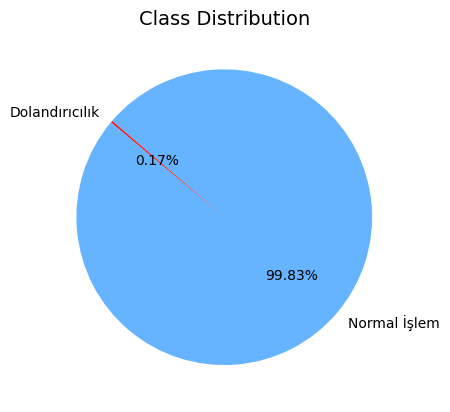

In [10]:
# Sınıfların yüzdelerini hesapla
fraud_counts = df['Class'].value_counts(normalize=True)

labels = ['Normal İşlem', 'Dolandırıcılık']
plt.pie(fraud_counts, labels=labels, autopct='%1.2f%%', colors=['#66b3ff', 'red'], startangle=140)
plt.title('Class Distribution', fontsize=14)
plt.show()

Class sütunumuzdaki verilerin dengesiz dağıldığını daha önce belirtmiştik. Tabloyu incelediğimizde de bunu net bir şekilde görebiliyoruz. Yapılan analizlere göre, Fraud (1) işlemlerin oranı yalnızca **%0.17** gibi oldukça düşük bir seviyede, bu da veri setinde ciddi bir sınıf dengesizliği olduğunu açıkça ortaya koyuyor. Bu dengesiz veri setini doğrudan tahmin modellerimiz ve analizlerimiz için kullanmak, algoritmanın işlemlerin çoğunlukla dolandırıcılık içermediğini varsaymasına neden olabilir ve bu durum **overfit** riskini artırabilir. Bu nedenle, modelleme sırasında bu dengesizlik dikkate alınmalı ve veri setindeki dengeyi sağlamak için uygun tekniklerin uygulanma ihtimali göz önünde bulundurulmalıdır.

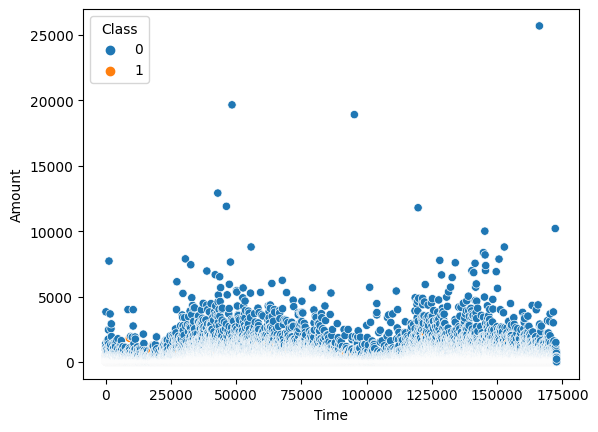

In [11]:
sns.scatterplot(data = df, x = 'Time', y = 'Amount', hue = 'Class') ;

Grafikten anladığımız kadarıyla, **normal işlemler (Class 0)** zaman içinde oldukça yoğun bir dağılım sergiliyor. Bu işlemlerin çoğunluğu, 5000'in altındaki miktarlar için yoğunlaşmış gibi görünüyor. Bu, normal kullanıcı davranışının çoğunlukla küçük ve düzenli işlem miktarlarını içerdiğini düşündürüyor. Aralarda ise daha yüksek miktarda işlemlerin olduğunu görebiliyoruz. Ancak bu işlemler, genel olarak düzenli ve yoğun bir şekilde yayılmış durumda.


Grafikte **dolandırıcılık işlemleri (Class 1)** turuncu noktalar ile temsil ediyor. Burada, dolandırıcılık işlemleri çok seyrek görünüyor. Bu durum dolandırıcılık işlemlerinin veri setinde çok daha nadir olduğunu doğruluyor (class imbalance).

Dolandırıcılık işlemlerinin düşük miktarlı olanları olduğu gibi, oldukça yüksek miktarlı olanları da var. Ancak bunların genellikle mavi noktaların (normal işlemlerin) arasında kaybolduğunu fark ediyoruz.
Dolandırıcılık işlemleri, genellikle diğer işlemlerle zaman bakımından örtüşüyor yani belirli bir zaman dilimine odaklanmıyor gibi görünüyor. Bu da dolandırıcılığın, günün herhangi bir zamanında gerçekleşebileceğini ve zamanın dolandırıcılık tespiti için belirgin bir ayırt edici özellik olmayabileceğini düşündürüyor. Bu yüzden, zamanı direkt bir ayrım unsuru olarak kullanmak yerine, zamana bağlı desenleri (örneğin, dolandırıcılıkların yoğunlaştığı belirli saat aralıkları olup olmadığını) daha derinlemesine analiz etmemiz gerekebilir.

Özetle;

* Bu grafikte, dolandırıcılık işlemlerinin oldukça seyrek ve dağınık olduğunu fark ediyoruz. Bu durum, veriyi dengeleme (resempling) ihtiyacını doğruluyor.
* Zaman ve miktar, dolandırıcılığı tespit etmek için tek başına yeterli olmayabilir. Ancak, diğer özelliklerle birlikte analiz edildiğinde katkı sağlayabilirler.


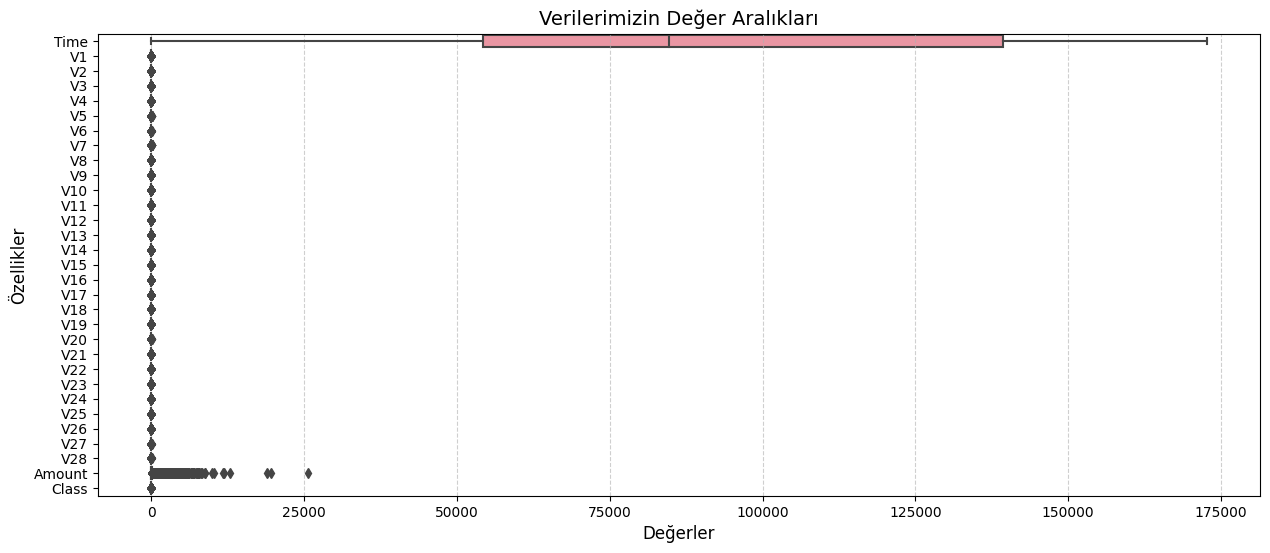

In [12]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, orient="h")
plt.title("Verilerimizin Değer Aralıkları", fontsize=14)
plt.xlabel("Değerler", fontsize=12)
plt.ylabel("Özellikler", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Sütunlarımızın genel dağılımlarını inceleyebilmek adına çizdirdiğimiz bu grafikte, Time ve Amount sütunlarının diğer özelliklere kıyasla çok farklı değer aralıklarına sahip olduğunu görüyoruz. Bu durum, özellikle mesafeye dayalı makine öğrenmesi algoritmalarında, büyük değer aralıklarının diğer sütunların etkisini gölgeleyebileceği anlamına gelir. Bu etkiyi ortadan kaldırmak ve özelliklerin eşit katkı sağlamasını sağlamak için, bu sütunlarda ölçeklendirme (scaling) işlemi yapılmalıdır.

* Time sütunu, en büyük değer aralığına sahip olup 175,000'e kadar çıkmaktadır. Bu, zaman boyutundaki geniş çeşitliliği temsil eder.
  
* Amount sütunu da geniş bir aralığa sahiptir, ancak diğer değişkenler genellikle daha dar bir aralıkta yoğunlaşmıştır.
  
* Diğer tüm özellikler, neredeyse sıfır çevresinde sıkışmış durumdadır. Bu, ölçekleme yapılmadığı takdirde Time ve Amount gibi sütunların diğer özellikleri gölgede bırakabileceğini ve analiz sonuçlarını etkileyebileceğini göstermektedir.

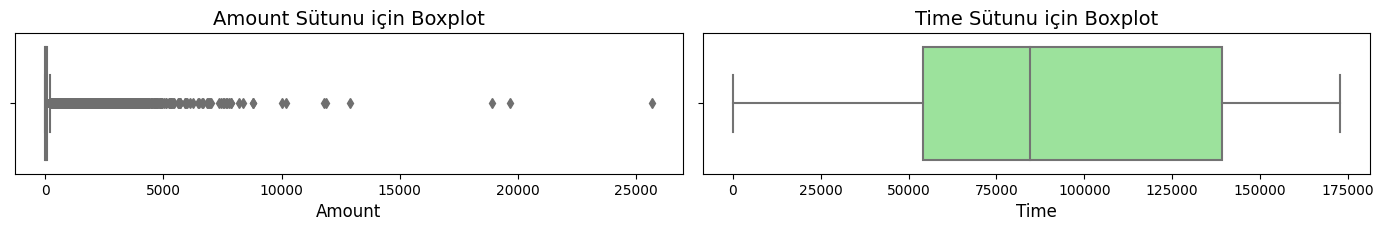

In [13]:

# Boxplot ile Amount sütunundaki outlier'ları görselleştirme
plt.figure(figsize=(14, 6))

plt.subplot(3, 2, 1)
sns.boxplot(x=df['Amount'], color = 'skyblue')
plt.title('Amount Sütunu için Boxplot', fontsize=14)
plt.xlabel('Amount', fontsize=12)

# Boxplot ile Time sütunundaki outlier'ları görselleştirme
plt.subplot(3, 2, 2)
sns.boxplot(x=df['Time'], color= 'lightgreen')
plt.title('Time Sütunu için Boxplot', fontsize=14)
plt.xlabel('Time', fontsize=12)

plt.tight_layout()
plt.show()

**Amount Sütunu:**

* İlk boxplotumuzu incelediğimzde, Amount sütununun geniş aralığa sahip olduğunu ve bazı outlier değerlere sahip olduğunu söyleyebiliriz. Bu outlier'lar, veri setinde nadir görülen ancak çok yüksek işlem miktarlarını ifade ediyor.

* Grafikteki değerlerin çoğunluğu, boxplot’un alt (sol) kısmında sıkışmış durumda, yani işlem miktarlarının büyük çoğunluğu daha küçük miktarlardan oluşuyor.

Outlier değerlerin varlığı, dolandırıcılık tespitinde önemli bir detay olabilir.
Çünkü dolandırıcılar genellikle sıra dışı işlem miktarlarıyla işlem yapabilir. Bu nedenle, bu outlier’ları yok etmek yerine RobustScaler gibi bir yöntemle ölçeklendirme yapmayı düşebiliriz.

------
**Time Sütunu:**

* İkinci boxplotumuza baktığımızda, Time sütununun daha düzgün bir dağılıma sahip olması dikkatimizi çekiyor. Boxplot’un genişliği, Time sütunundaki değerlerin geniş bir aralığa yayıldığını ifade ediyor.
* Time sütunu, işlemin başlangıcından itibaren geçen süreyi (saniye cinsinden) ifade ediyor. Dolayısıyla, outlier gibi görünen aşırı değerler bulunmuyor. Bu da Time sütununun daha dengeli bir özellik olduğunu gösteriyor..

> ## 2.2 Veriler Arasındaki İlişkinin Grafiklerle İncelenmesi

>> Dolandırıcılığın Yoğun Olduğu Saatler

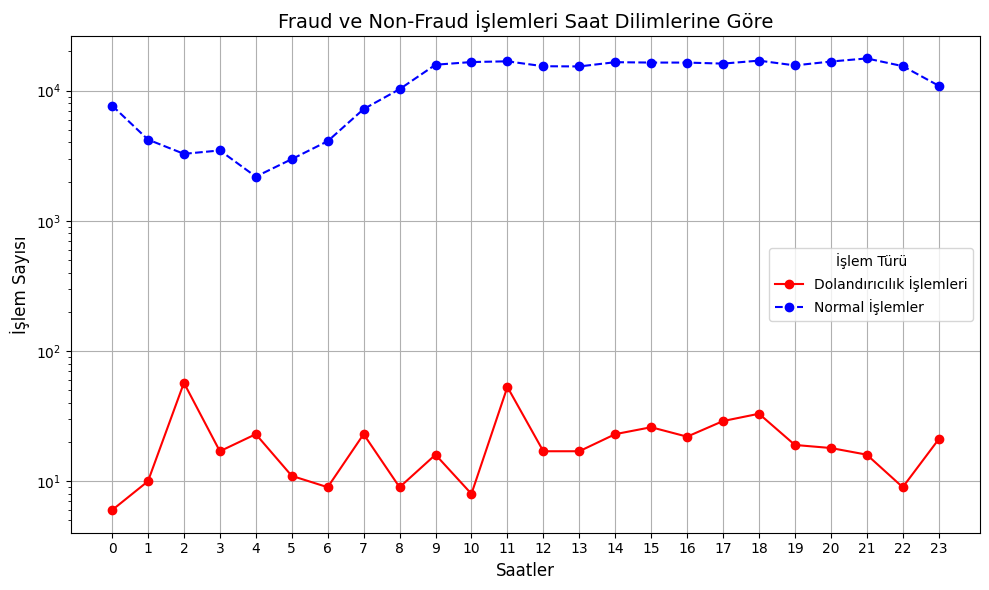

In [14]:
# Saat dilimlerini oluşturmak için Time sütununu dönüştürme
hourly_data = df.copy()
hourly_data['Hour'] = pd.to_datetime(hourly_data['Time'], unit='s').dt.hour

# Fraud ve non-fraud işlemleri için saat dilimlerine göre gruplama
fraud_data = hourly_data[hourly_data['Class'] == 1].groupby('Hour').size()  # Fraud işlemler
non_fraud_data = hourly_data[hourly_data['Class'] == 0].groupby('Hour').size()  # Non-Fraud işlemler

# Grafik çizimi
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_yscale('log')  # Y eksenini logaritmik olarak ayarlar.

# Fraud işlemlerini çiz
ax.plot(fraud_data.index, fraud_data.values, '-o', label='Dolandırıcılık İşlemleri', c='red')

# Non-Fraud işlemlerini çiz
ax.plot(non_fraud_data.index, non_fraud_data.values, '--o', label='Normal İşlemler', c='blue')


# Başlık ve etiketler
ax.set_title('Fraud ve Non-Fraud İşlemleri Saat Dilimlerine Göre', fontsize=14)
ax.set_xlabel('Saatler', fontsize=12)
ax.set_ylabel('İşlem Sayısı', fontsize=12)

# Grid, legend ve x-axis düzenlemesi
ax.grid(True)
plt.xticks(range(24))  # Saat dilimlerini 0-23 arasında göster
plt.legend(title='İşlem Türü')

# Grafik gösterimi
plt.tight_layout()
plt.show()


Bu grafikte, fraud (dolandırıcılık) ve non-fraud (normal işlemler), saat dilimlerine göre işlem sayıları üzerinden incelenmiştir. Normal işlemlerin sayısı, dolandırıcılık işlemlerine kıyasla oldukça yüksek olduğu için verilerin daha iyi görselleştirilmesi amacıyla logaritmik ölçek kullanılmıştır. Lineer bir ölçekte dolandırıcılık işlemleri, normal işlemler arasındaki büyük fark nedeniyle görünmez hale gelebilirdi. Logaritmik ölçek, hem büyük hem de küçük değerleri aynı anda daha açık bir şekilde analiz etme olanağı sunar.

Grafiğin detaylarına bakıldığında, normal işlemlerin (mavi çizgi) günün her saatinde oldukça yoğun olduğu görülmektedir. Özellikle sabah saat 9:00 ile akşam 18:00 arasında işlem sayısında zirve yaşanmaktadır. Bu durum, kullanıcıların genellikle iş saatlerinde daha fazla işlem yaptığına işaret etmektedir. Gece saatlerinde de işlem sayıları devam etmekle birlikte, günün diğer zamanlarına göre azalma gözlemlenmektedir.

Dolandırıcılık işlemleri (kırmızı çizgi) ise çok daha düşük bir sıklıkta gerçekleşmektedir. Ancak, belirli saatlerde (örneğin gece yarısı, sabaha karşı ve öğle saatlerinde) dolandırıcılık işlemlerinde görece bir artış görülmektedir. Bu durum, dolandırıcıların genellikle daha az dikkat çekeceğini düşündükleri saat dilimlerini tercih ettiği şeklinde yorumlanabilir. Ayrıca, sabah 11:00 civarındaki artış, dolandırıcıların sistemlerin daha aktif olduğu saatlerde de işlem yapmayı denediklerini gösterebilir.

Bu grafik, dolandırıcılık işlemlerinin saat dilimlerine göre dağılımını anlamak ve güvenlik önlemlerini optimize etmek açısından önemli bir içgörü sağlamaktadır. Örneğin, dolandırıcılığın yoğun olduğu saatlerde güvenlik sistemlerini güçlendirmek ya da belirli saatler için anomali tespiti algoritmalarını daha hassas hale getirmek, bu tür olayların önlenmesine yardımcı olabilir. İleriye dönük olarak, saat bazında dolandırıcılık oranlarının toplam işlemlere göre analizi yapılabilir ve dolandırıcılıkla mücadele mekanizmaları bu verilerle iyileştirilebilir.

> > İşlem Miktarlarının İncelenmesi

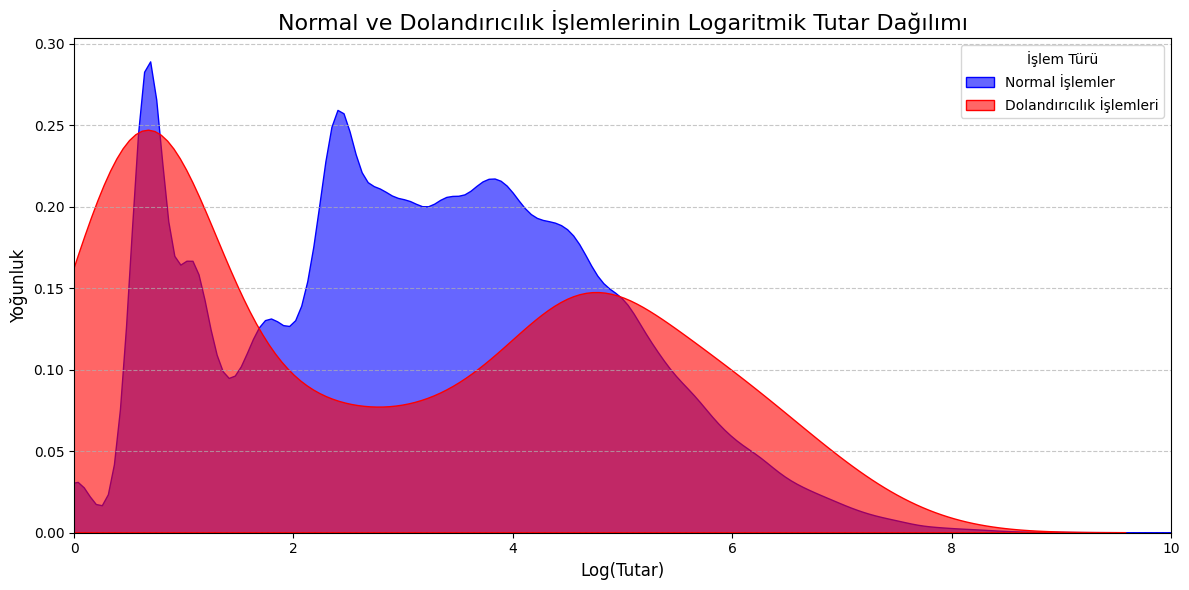

In [15]:
# Verileri logaritmik ölçeğe dönüştürelim (0 değerlerinden kaçınmak için 1 eklenir)
df['Log_Amount'] = np.log1p(df['Amount'])  # log1p(x) = log(x + 1)

# Dolandırıcılık ve normal işlemleri ayıralım
fraud_amount = df[df['Class'] == 1]['Log_Amount']
non_fraud_amount = df[df['Class'] == 0]['Log_Amount']

# Grafik boyutunu ayarlayalım
plt.figure(figsize=(12, 6))

# Non-Fraud (Normal İşlemler) için KDE çizimi
sns.kdeplot(non_fraud_amount, fill=True, color="blue", label="Normal İşlemler", alpha=0.6)

# Fraud (Dolandırıcılık İşlemleri) için KDE çizimi
sns.kdeplot(fraud_amount, fill=True, color="red", label="Dolandırıcılık İşlemleri", alpha=0.6)

# Başlık ve etiketler
plt.title("Normal ve Dolandırıcılık İşlemlerinin Logaritmik Tutar Dağılımı", fontsize=16)
plt.xlabel("Log(Tutar)", fontsize=12)
plt.ylabel("Yoğunluk", fontsize=12)
plt.legend(title="İşlem Türü", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# X eksenini düzenleme (Opsiyonel)
plt.xlim(0, 10)  # Logaritmik ölçek olduğu için uygun aralık seçildi

# Grafik gösterimi
plt.tight_layout()
plt.show()

Bu grafikte, Normal İşlemler ve Dolandırıcılık İşlemleri logaritmik tutarlarına göre karşılaştırılmıştır. Normal işlemler, logaritmik ölçekte 1 ile 5 arasında yoğun bir dağılıma sahipken, dolandırıcılık işlemleri daha çok düşük tutarlarda yoğunlaşmaktadır. Bu, dolandırıcıların genellikle düşük tutarlı işlemlerle sistemleri test etmeyi tercih ettiğini ve dikkat çekmeden hareket etmeye çalıştığını gösterebilir.

Grafik, dolandırıcılık işlemlerinin logaritmik ölçekte 0-2 aralığında yüksek bir yoğunluk gösterdiğini, 3-6 aralığında ise normal işlemlerle karşılaştırıldığında düşük kaldığını ortaya koymaktadır. Normal işlemler ise orta düzey tutarlarda zirve yaparak daha geniş bir yelpazede dağılmıştır. Bu durum, normal kullanıcıların farklı tutarlarda işlem yaptığını ve dolandırıcılık işlemlerinin bu aralıklarda azaldığını gösteriyor.

Yüksek tutarlarda ise dolandırıcılık işlemleri neredeyse yok denecek kadar azalmaktadır. Bu da dolandırıcıların büyük tutarlarda işlem yapmaktan kaçındığını düşündürmektedir.
Buradan, dolandırıcılık algılama sistemleri için düşük tutarlı işlemler üzerinde daha fazla dikkat edilmesi gerektiği, orta ve yüksek tutarlı işlemler için ise daha spesifik izleme yöntemlerinin kullanılabileceği sonucu çıkarılabilir.

# 3. Özellik Ölçeklendirme (Feature Scaling)

In [16]:
# Feature Scaling
rob_scaler = RobustScaler()
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Time ve Amount sütunlarını kaldırıyoruz
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Sütun sıralamasını düzenliyoruz
columns_order = ['scaled_time', 'scaled_amount'] + [col for col in df.columns if col not in ['scaled_time', 'scaled_amount']]
df = df[columns_order]

df.head()

,scaled_time,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log_Amount
0,-0.994983,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.014760
1,-0.994983,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,1.305626
2,-0.994972,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.939276
3,-0.994972,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.824306
4,-0.994960,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.262539


Feature scaling işlemi, modelin öğrenme sürecini daha verimli hale getirmeyi amaçlar. Veriler aynı ölçek üzerinde olduğunda, algoritmalar daha hızlı ve doğru bir şekilde öğrenebilir. Bu sebeple, **RobustScaler** kullanarak, **Amount** ve **Time** sütunlarındaki verileri daha tutarlı hale getirdik.
Önceden gözlemlediğimiz üzere, bu sütunlardaki **aykırı değerler (outliers)** modelin doğruluğunu olumsuz etkileyebilecek bir durum yaratıyordu. **RobustScaler**, verilerin ortalaması ve standart sapması yerine verilerin medyanı ve çeyrek aralığı kullanarak ölçeklendirme yapar. Bu nedenle, normal dağılımın dışında olan veya aykırı değerlere sahip verilerin olduğu durumlarda daha iyi sonuçlar verir. Aykırı değerler üzerinde daha az etki yapması, modelin genel doğruluğunu bozmadan veriyi düzenlememize olanak tanır.

Sonuç olarak, bu ölçeklendirme işlemi, **aykırı değerlerin etkisini ortadan kaldırarak**, modelin öğrenme sürecini optimize eder. Böylece, daha sağlıklı ve güvenilir sonuçlar elde edilir. Ayrıca, **veri setindeki benzersiz özellikler korunarak** modelin doğruluğu artırılır. Aykırı değerleri çıkarsaydık veya manipüle etseydik, bu verilerin özgünlüğü bozulur ve modelin başarısı düşerdi. Bu nedenle, aykırı değerler üzerinde herhangi bir işlem yapılmadan veriye uygun bir şekilde ölçeklendirme işlemi gerçekleştirdik. Bu yaklaşım, modelin başarı oranını artırarak, daha güvenilir ve anlamlı tahminler yapılmasına olanak tanır.



# 4. Dengelenmemiş Veri için Çözümler

Dengelenmemiş veri seti, farklı sınıflara ait örneklerin sayısında ciddi bir dengesizlik olduğunda ortaya çıkar. Örneğin, bir modelin doğruluğu %95 gibi yüksek görünebilir, ancak yalnızca çoğunluk sınıfını tahmin ediyorsa, bu durum azınlık sınıfını göz ardı ettiğini gösterir. Böyle bir durumda, azınlık sınıfı yeterince temsil edilmediği için model gerçek performansını sergileyemez.

Bu sorunu çözmek için oversampling (azınlık sınıfını çoğaltma), undersampling (çoğunluk sınıfını azaltma) gibi yöntemler kullanılabilir. Bu yaklaşımlar, modelin her iki sınıfı da doğru bir şekilde öğrenmesine yardımcı olur ve daha dengeli tahminler sağlar.

> ## **Over Sampling ve Under Sampling Görselleştirilmesi**

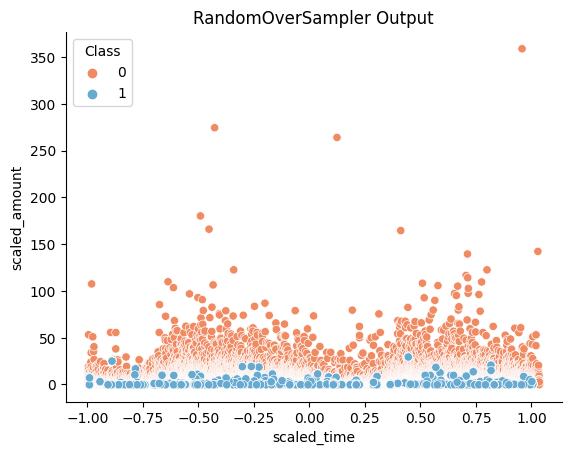

In [17]:
X = df[['scaled_time', 'scaled_amount']]
y = df['Class']

# Oversampling için veri hazırlığı
ros = RandomOverSampler(random_state=45)
X_resampled, y_resampled = ros.fit_resample(X, y)

# DataFrame oluşturma
df_resampled = pd.DataFrame(X_resampled, columns=df.columns[:-1])  # X'teki özellikler
df_resampled['Class'] = y_resampled  # y'deki hedef sınıf

# Scatter plot oluşturma
sns.scatterplot(data=df_resampled, x='scaled_time', y='scaled_amount', hue='Class', palette={0: '#ef8a62', 1: '#67a9cf'})

# Başlık ve görselleştirme
plt.title("RandomOverSampler Output")
sns.despine()
plt.show()

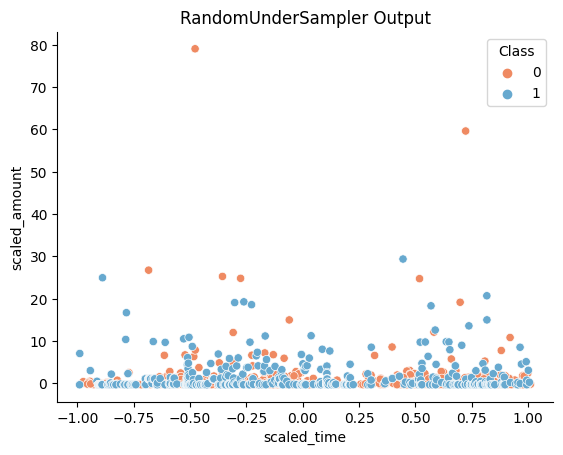

In [18]:
# Undersampling için veri hazırlığı
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

# DataFrame oluşturma
df_resampled = pd.DataFrame(X_resampled, columns=df.columns[:-1])  # X'teki özellikler
df_resampled['Class'] = y_resampled  # y'deki hedef sınıf

# Scatter plot oluşturma
sns.scatterplot(data=df_resampled, x='scaled_time', y='scaled_amount', hue='Class', palette={0: '#ef8a62', 1: '#67a9cf'})

# Başlık ve görselleştirme
plt.title("RandomUnderSampler Output")
sns.despine()
plt.show()


İlk grafikte, veri setindeki sınıflar arasındaki dengesizliği gidermek için nadir görülen 'fraud' (dolandırıcılık) sınıfı örnekleri çoğaltılarak veri seti dengelenmiştir. Bu işlem sonucunda, dolandırıcılık işlemleri ve normal işlemler **eşit sayıda** gözlem içerir hale getirilmiştir. Ancak, bu çoğaltma işlemi sırasında dolandırıcılık sınıfındaki örnekler birden fazla kez tekrar edildiği için, modelin öğrenme sürecinde **tekrarlayan verilere** maruz kalma riski ortaya çıkabilir. Bu durum, modelin **genelleme yeteneğini** olumsuz etkileyerek yeni veriler üzerinde **düşük performans** göstermesine neden olabilir.

İkinci grafikte, veri setindeki dengesizliği gidermek amacıyla 'non-fraud' (normal işlemler) sınıfındaki fazla gözlemler rastgele şekilde kaldırılarak azaltılmıştır. Bu işlem sırasında, 'non-fraud' sınıfındaki gözlem sayısı, 'fraud' (dolandırıcılık) sınıfındaki gözlem sayısına **eşitlenmiştir** ve veri seti dengelenmiş, böylece sınıflar arasındaki dengesizlik giderilmiştir.

*Veri dengeleme yöntemlerinden hangisinin daha uygun olduğu, veri setindeki dengesizliğin boyutuna ve 'fraud' sınıfının örnek sayısına bağlıdır. Buradaki genel amacımız, modelin genel doğruluğunu artırmak ve dengesiz verinin etkisini azaltmaktır.*

> ## 4.1 Dengelenmemiş Veri ile Logistic Regression

In [19]:
# Özellik ve hedef değişkeni seçme
X = df.drop(columns=['Class'])  # Tahmin edilecek sınıf harici tüm kolonlar
y = df['Class']

# Veri setini eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Logistic Regression modeli
logistic_model = LogisticRegression(max_iter=6000, solver='saga')
logistic_model.fit(X_train, y_train)

# Test seti üzerinde tahmin
y_pred = logistic_model.predict(X_test)

In [21]:
accuricy = logistic_model.score(X_train,y_train)
print (f"Model doğruluk skoru= {accuricy}")

Model doğruluk skoru= 0.9991723681306555


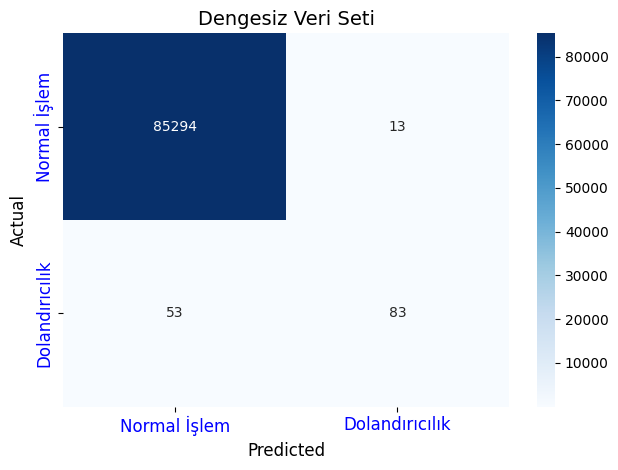

In [22]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    # Eksenler için etiketler
    class_names = ['Normal İşlem', 'Dolandırıcılık']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title(title, fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)

    plt.xticks(fontsize=12, color="blue")
    plt.yticks(fontsize=12, color="blue")

    plt.tight_layout()
    plt.show()

# Grafik çizim
plot_confusion_matrix(y_test, y_pred, "Dengesiz Veri Seti")


* Normal işlemler için 83294 (TP) doğru, 13 (FP) yanlış toplam 85307 tahmin yapılmış.
* Dolandırıcılık sınıfı için 53 (FN) yanlış, 83 (TN) doğru toplam 136 tahmin yapılmış

Modelimizin doğruluk skorunun **0.9992** gibi oldukça yüksek bir değerde olduğunu görüyoruz. İlk bakışta modelin mükemmel çalıştığını düşünebiliriz, ancak bu yanıltıcı bir metriktir çünkü veri setimiz dengesizdir. Bu durum, **Confusion Matrix** incelendiğinde daha net bir şekilde anlaşılmaktadır.

Model, dolandırıcılık işlemlerini yanlış tahmin etse bile, çoğunluk sınıfını oluşturan normal işlemleri doğru bir şekilde tahmin ederek yüksek bir doğruluk oranı sağlamaktadır. Bu, modelin **çoğunluk sınıfını tahmin etmede başarılı olduğunu**, ancak **azınlık sınıfını tahmin etmekte zorlandığını** göstermektedir. Özetle, modelimiz %99 doğruluk oranıyla normal işlem sınıfını doğru bir şekilde sınıflandırmaktadır, ancak dolandırıcılık sınıfında yetersiz kalmaktadır.

Bu nedenle, **dengesiz veri setlerinde accuracy (doğruluk)** performansı değerlendirmek için tek başına yeterli bir ölçüt değildir. Daha dengeli ve anlamlı bir değerlendirme için precision, recall ve f1-score gibi metrikler kullanılmalıdır.

![](http://miro.medium.com/v2/resize:fit:1400/format:webp/1*77zrZeWaGRFL7MWWqIqxZA.png)


In [23]:
logistic_model.score(X_train,y_train)
print("Dengesiz veri seti sonuçları:")
print(classification_report(y_test, y_pred, target_names=['Normal işlem','Dolandırıcılık']))


Dengesiz veri seti sonuçları:
                precision    recall  f1-score   support

  Normal işlem       1.00      1.00      1.00     85307
Dolandırıcılık       0.86      0.61      0.72       136

      accuracy                           1.00     85443
     macro avg       0.93      0.81      0.86     85443
  weighted avg       1.00      1.00      1.00     85443



**Precision**, modelin verdiği pozitif tahminlerin ne kadarının doğru olduğunu ölçer. Yani, "**Model tarafından dolandırıcılık olarak tahmin edilen işlemlerin gerçekten dolandırıcılık olma oranı**" olarak tanımlayabiliriz.
* Model, **normal işlemleri** %100 doğrulukla sınıflandırırken, **dolandırıcılık işlemlerinde** precision değeri %86’dır. Bu, dolandırıcılık olarak tahmin edilen işlemlerin %86'sının gerçekten dolandırıcılık olduğunu, ancak kalan %14'ünün yanlış tahmin edildiğini gösteriyor.

**Recall**, modelin pozitif örnekleri ne kadar doğru bir şekilde tespit ettiğini ölçer. Yani, "**Gerçekten dolandırıcılık olan işlemlerin ne kadarını doğru tahmin edebildik?**" sorusunu yanıtlar.
* Model, **normal işlemleri** %100 doğrulukla tespit edebilmiştir. Ancak, **dolandırıcılık işlemlerinde** recall değeri %61’dir. Bu, dolandırıcılık işlemlerinin %39'unun model tarafından "normal işlem" olarak yanlış sınıflandırıldığını gösteriyor. **Recall’in düşük olması, modelin dolandırıcılıkları tespit etmekte zorlandığını ifade ediyor.**

**F1-score**, precision ve recall arasındaki dengeyi ölçen bir metriktir. Dengesiz veri setlerinde daha güvenilir bir performans ölçütü olarak kullanılır.
* **Normal işlemler** için F1-score 1.00 olup, bu sınıfta modelin oldukça başarılı olduğunu gösteriyor. Ancak **dolandırıcılık işlemlerinde** F1-score 0.72’ye düşmüştür. Bu, dolandırıcılık sınıfında hem precision hem de recall’in daha düşük olmasından kaynaklanmaktadır. Model, dolandırıcılıkları tespit etmede sınırlı başarıya sahiptir.


*Bu analiz, modelimizin normal işlemleri çok iyi bir şekilde sınıflandırdığını, ancak dolandırıcılık işlemlerini tespit etmekte zorlandığını gösteriyor. Özellikle dolandırıcılık işlemlerinde düşük recall (%61), modelin birçok dolandırıcılık işleminde başarısız olduğunu ve yanlış negatif oranının yüksek olduğunu ortaya koyuyor.Bu nedenle, dengesiz veri seti sorununu çözmek için veri dengeleme yöntemlerini kullanarak model performansını artırmak gereklidir.*


## RESAPMLING

**Yeniden örnekleme (Resampling)**, dengesiz veri setlerini daha dengeli hale getirmek için kullanılan bir tekniktir. Bu işlem, **azınlık sınıfına yeni örnekler eklenerek (oversampling)** veya **çoğunluk sınıfından bazı örnekler çıkarılarak (undersampling)** gerçekleştirilir. Böylece, modellerin her iki sınıf için de **daha iyi bir şekilde öğrenmesi** sağlanır.

Şimdi, veri setimizi yeniden örnekleme yöntemlerini kullanarak dengeleyecek ve bu yöntemlerin modellerimizin başarısını nasıl etkilediğini inceleyeceğiz.  İlk aşamada, düşük maliyetli ve uygulanması kolay olduğu için **Logistic Regression** kullanıyoruz. Bu yöntem, bize **veri setimiz ve yeniden örnekleme tekniklerinin etkisi hakkında hızlıca fikir verecek**. Elde edilen sonuçlara göre, daha sonra veri setimizin ihtiyaçlarına **en uygun makine öğrenimi algoritmasını** seçerek performansı optimize etmeyi planlıyoruz.

![](http://blog.talent500.co/wp-content/uploads/2024/05/images-21-3.png)

> ## 4.2 Oversampling ile Logistic Regression

In [24]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

unique, count =np.unique(y_train_smote, return_counts=True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{0: 199008, 1: 199008}

In [25]:
model_smote = LogisticRegression(solver='saga', max_iter=6000, random_state=42)  # saga çözücüsü kullanıldı
model_smote.fit(X_train_smote, y_train_smote)

# Test seti üzerinde tahmin
y_pred_smote = model_smote.predict(X_test)

In [26]:
accuricy_smote = model_smote.score(X_train_smote,y_train_smote)
print (f"Model doğruluk skoru= {accuricy_smote}")

Model doğruluk skoru= 0.9470197178002895


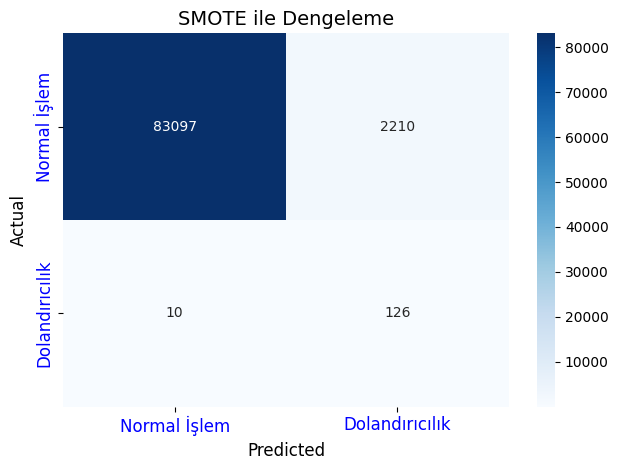

In [27]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    # Eksenler için etiketler
    class_names = ['Normal İşlem', 'Dolandırıcılık']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title(title, fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)

    plt.xticks(fontsize=12, color="blue")
    plt.yticks(fontsize=12, color="blue")

    plt.tight_layout()
    plt.show()

# Grafik çizim
plot_confusion_matrix(y_test, y_pred_smote, "SMOTE ile Dengeleme")


* Normal işlemler için 83097 (TP) doğru, 2210 (FP) yanlış toplam 85307 tahmin yapılmış.
* Dolandırıcılık sınıfı için 10 (FN) yanlış, 126 (TN) doğru toplam 136 tahmin yapılmış

Dengesiz veri setiyle çalışırken, modelimizin doğruluk oranı %99 gibi çok yüksek bir değerdeydi. Ancak, bu yüksek doğruluk oranı, çoğunluk sınıfı olan normal işlemleri doğru tahmin ederek elde edildiğinden yanıltıcıdır. Azınlık sınıfı olan dolandırıcılık işlemleri yeterince iyi tahmin edilememiştir. SMOTE yöntemi ile azınlık sınıfını artırarak veri setini dengelediğimizde, modelin doğruluk oranı **%94,7**'ye düştü. Bu doğruluk skorundaki düşüş, SMOTE'un azınlık sınıfını daha iyi temsil etmeye odaklandığını ve modelin her iki sınıfı da daha dengeli bir şekilde tahmin etmeye başladığını göstermektedir.


In [28]:
# Performans değerlendirme
print("SMOTE ile dengeleme sonuçları:")
print(classification_report(y_test, y_pred_smote, target_names=['Normal işlem', 'Dolandırıcılık']))

SMOTE ile dengeleme sonuçları:
                precision    recall  f1-score   support

  Normal işlem       1.00      0.97      0.99     85307
Dolandırıcılık       0.05      0.93      0.10       136

      accuracy                           0.97     85443
     macro avg       0.53      0.95      0.54     85443
  weighted avg       1.00      0.97      0.99     85443



SMOTE yöntemi ile dengelenmiş veri setiyle yapılan modelde doğruluk skoru **%94,7** iken, Confusion Matrix'ten elde edilen doğruluk oranı **%97** olarak görülmektedir. Bu fark, **eğitim verisinin SMOTE ile dengelenmesinden** ve **test verilerinin çoğunluk sınıfındaki tahminlerin doğruluğunun yüksek olmasından kaynaklanmaktadır**. Test setindeki yüksek doğruluk oranı, dolandırıcılık sınıfının yeterince iyi tespit edilemediğini gizleyebilir. **Yüksek doğruluk, modelin çoğunluk sınıfı üzerindeki başarılı tahminlerinden dolayı yanıltıcı olabilir**.

Confusion Matrix'e baktığımızda, normal işlemler için doğru tahmin oranının %97 civarında olduğu görülüyor. Ancak, dolandırıcılık işlemlerindeki **precision** değeri sadece %5, **recall** değeri ise %93 gibi oldukça yüksek bir seviyeye ulaşmaktadır. Bu durum, modelin **çoğu dolandırıcılık işlemini doğru bir şekilde tespit ettiğini ancak yanlış pozitif tahminlerin fazla olduğunu** göstermektedir. Yani, **model azınlık sınıfındaki dolandırıcılık işlemlerini tespit etme konusunda başarılı olsa da, çok sayıda yanlış alarm vermektedir**.

*SMOTE yöntemi sayesinde modelin dolandırıcılık sınıfını yakalama kabiliyeti artmış, ancak yanlış pozitif oranı da yükselmiştir.*

> ## 4.3 Random Under-Sampling ile Logistic Regression

In [29]:
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Logistic Regression modeli
model_under = LogisticRegression(solver='saga', max_iter=6000, random_state=42)
model_under.fit(X_train_under, y_train_under)

# Test seti üzerinde tahmin
y_pred_under = model_under.predict(X_test)


In [30]:
accuricy_under = model_under.score(X_train_under,y_train_under)
print (f"Model doğruluk skoru= {accuricy_under}")

Model doğruluk skoru= 0.952247191011236


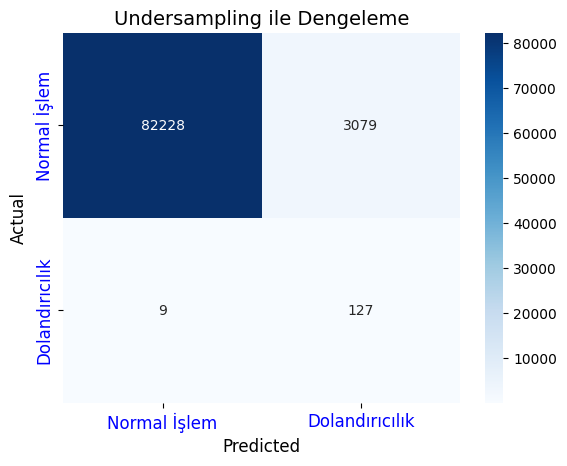

In [31]:
# Confusion Matrix görselleştirme
matplotlib.rcParams['text.usetex'] = False

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal İşlem', 'Dolandırıcılık'], yticklabels=['Normal İşlem', 'Dolandırıcılık'])
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)

    plt.xticks(fontsize=12, color="blue")
    plt.yticks(fontsize=12, color="blue")
    plt.yticks(fontsize=12, color="blue")

    plt.show()

plot_confusion_matrix(y_test, y_pred_under, "Undersampling ile Dengeleme")


* Normal işlemler için 82228 (TP) doğru, 3079 (FP) yanlış toplam 85307 tahmin yapılmış.
* Dolandırıcılık sınıfı için 9 (FN) yanlış, 127 (TN) doğru toplam 136 tahmin yapılmış

In [32]:
# Performans değerlendirme
print("Undersampling ile dengeleme sonuçları:")
print(classification_report(y_test, y_pred_under))

Undersampling ile dengeleme sonuçları:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85307
           1       0.04      0.93      0.08       136

    accuracy                           0.96     85443
   macro avg       0.52      0.95      0.53     85443
weighted avg       1.00      0.96      0.98     85443



Undersampling yöntemi kullanıldığında, dolandırıcılık sınıfı için **recall** değeri **%93** seviyelerinde kalmıştır, bu da **modelin azınlık sınıfını yakalama konusunda etkili olduğunu** göstermektedir. Ancak **precision** değeri yalnızca **%4**’tedir, bu da modelin **dolandırıcılık** işlemleri hakkında çok sayıda **yanlış pozitif** tahmin yaptığına işaret eder. Yani, model dolandırıcılık işlemlerini doğru bir şekilde tespit etse de, oldukça fazla sayıda yanlış alarm vermektedir.

Undersampling, *veri setindeki çoğunluk sınıfının örneklerini azaltarak azınlık sınıfını daha iyi temsil etmeye yardımcı olmuş ve dolandırıcılık işlemleri üzerindeki performansı artırmıştır*. Ancak, *bu yöntem veri setinin toplam boyutunu küçültüğü için modelin genel doğruluğunu olumsuz etkileyebilir*. Eğitim veri setinin küçülmesi, modelin genelleme kabiliyetinde sınırlamalara yol açabilir, dolayısıyla azınlık sınıfını tespit etme konusunda daha başarılı olsa da, *çoğunluk sınıfındaki genel doğruluk düşer*.

## Yöntem Seçimi

Fraud detection (dolandırıcılık tespiti) çalışmalarında, doğru yöntemi seçmek, amacımıza göre büyük bir önem taşır. Eğer amacımız *dolandırıcılık vakalarını kaçırmamaksa*, *recall* değeri ön planda olmalıdır. Özellikle bankacılık ve sigorta gibi sektörlerde, dolandırıcılıkla ilgili büyük finansal kayıpların önüne geçmek kritik olduğundan, yanlış alarmlar tolere edilebilir. Bu durumda, yalnızca ek inceleme gerektiren yanlış alarmlar, dolandırıcılık vakalarını en yüksek seviyede tespit etmeye çalışan yöntemler için bir maliyet olarak kabul edilebilir.

Dengesiz veri setlerinde model genellikle sahte işlemleri normal olarak sınıflandırabilir, yani False Negative (FN) hataları yapar. Recall, bu hataları minimize etmek için kullanılır ve dolayısıyla sahte işlemleri yakalama konusunda en önemli ölçütlerden biridir. Recall, şu şekilde hesaplanır:

Recall = (TP)/(TP + FN)

Veri dengesizliği nedeniyle Accuracy ve Precision her zaman doğru sonuçlar vermez. Accuracy çoğunlukla normal işlemlerden oluştuğu için yanıltıcı olabilir, Precision ise False Positive (FP) hataları ile düşebilir. Bu nedenle, recall’ı artırmak sahte işlemleri yakalamada daha büyük önem taşır.

Diğer yandan, *yanlış alarmları minimize etmek* önceliğimizse, *precision* değerini artırmaya odaklanmalıyız. Bu durum, müşteri memnuniyetinin çok kritik olduğu e-ticaret gibi sektörlerde öne çıkar. Yanlış alarmlar, müşteri kaybına ve olumsuz deneyimlere yol açabileceği için, bu senaryoda daha hassas modeller ve özellik mühendisliği, threshold optimizasyonu gibi teknikler devreye girebilir.

Bazı durumlarda ise hem dolandırıcılığı tespit etmek hem de yanlış alarmları azaltmak hedeflenebilir. Bu tür durumlar için, *recall* ve *precision* arasında bir denge sağlayan *F1-Score* gibi metriklere odaklanmak uygun olabilir. Özellikle büyük ölçekli sigorta operasyonlarında bu denge kritik bir rol oynar.

Bizim projemizde, dolandırıcılık vakalarını kaçırmamak önceliğimiz olduğu için, recall değeri en önemli metrik olarak öne çıkmaktadır.

Recall değerlerinin her iki modelde de %93 seviyelerinde olduğunu gözlemliyoruz. Bu nedenle, precision ve F1-Score değerlerine odaklanarak daha dengeli bir performans sergileyen modelin tercih edilmesi gerektiğini söyleyebiliriz. SMOTE yönteminde F1-Score değeri daha yüksek olduğu için dolandırıcılık işlemleri üzerinde daha dengeli bir performans elde ediliyor. Bu durumda, modelimizde dolandırıcılığı daha dengeli bir şekilde tespit eden ve yanlış pozitifleri minimize eden SMOTE tabanlı model tercih edilebilir.

# 5. Model Eğitimi

> ## 1. Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Modeli oluştur
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Modeli eğit
rf_model.fit(X_train_smote, y_train_smote)

# Test seti üzerinde tahmin yap
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]


Accuracy Score: 0.9995903701883126
Confusion Matrix:
 [[85288    19]
 [   16   120]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.86      0.88      0.87       136

    accuracy                           1.00     85443
   macro avg       0.93      0.94      0.94     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9780189664457575


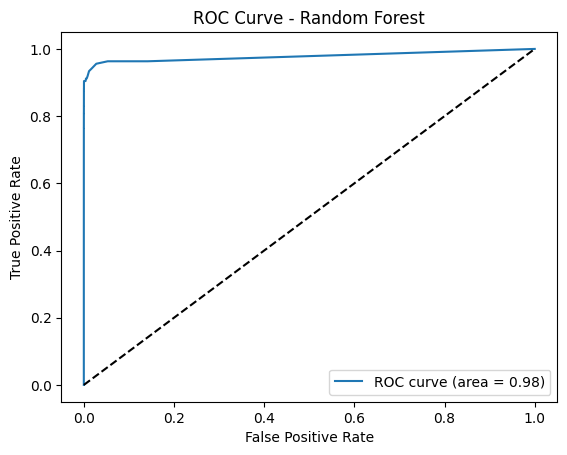

In [34]:
# Confusion Matrix ve Classification Report
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# ROC-AUC Skoru
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("ROC-AUC Score:", auc_rf)

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label="ROC curve (area = %0.2f)" % auc_rf)
plt.plot([0, 1], [0, 1], "k--")  # Rastgele tahmin çizgisi
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()

Random Forest modeliyle eğitim yaparak elde ettiğimiz sonuçlar, modelimizin dolandırıcılık tespitinde oldukça başarılı olduğunu göstermektedir.

ROC-AUC Skoru'na baktığımızda modelimizin genel ayrıştırma performansının çok iyi olduğunu görüyoruz. ROC-AUC, sınıflar arasındaki ayrımı ölçer ve bu modelin dolandırıcılığı tespit etme yeteneğinin oldukça güçlü olduğunu söyleyebiliriz. Modelimiz, dolandırıcılık tespitinde dengeli bir performans sergiliyor ve sınıflar arasında, özellikle dolandırıcılığı yakalama konusunda iyi bir başarı elde etmiş durumda.

Test setindeki dengesiz veri yapısına rağmen, hem dolandırıcılık hem de normal işlemleri ayırt etmede etkili bir sonuç almayı başarmışız. Ancak, dolandırıcılık sınıfında (Class 1) hâlâ ufak bir hata oranı mevcut (Recall = 0.88). Bu, bazı dolandırıcılık işlemlerinin gözden kaçabileceğini gösteriyor. Bu durum, daha hassas bir model elde etmek için ileri geliştirmeler yapmamız gerekebileceğini işaret ediyor.

> ## 2. SVM

In [35]:
# Verileri ölçeklendirme
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train)
X_test_smote = scaler.transform(X_test)

# SVM Modeli tanımla ve eğit
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability = True)
svm_model.fit(X_train_smote, y_train)

y_pred = svm_model.predict(X_test_smote)
y_pred_proba = svm_model.predict_proba(X_test_smote)[:, 1]

# Performans ölçümleri
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.9993914071369217
Confusion Matrix:
 [[85299     8]
 [   44    92]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.92      0.68      0.78       136

    accuracy                           1.00     85443
   macro avg       0.96      0.84      0.89     85443
weighted avg       1.00      1.00      1.00     85443



ROC-AUC Score: 0.9649915805819673


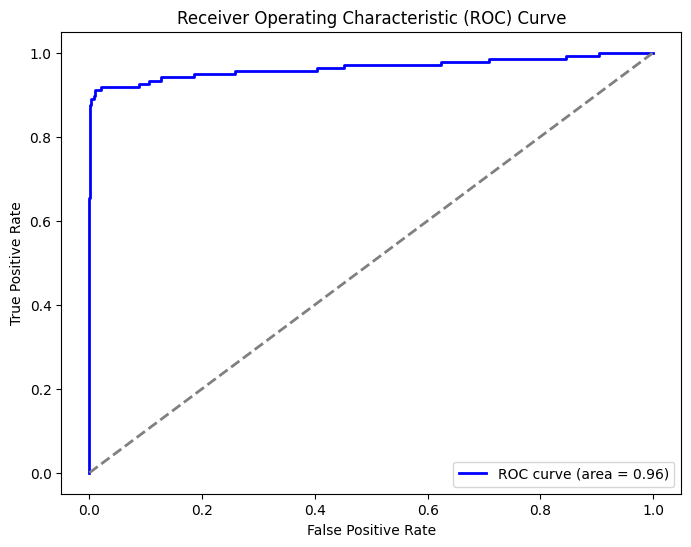

In [36]:
# ROC eğrisini çizme
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

# ROC Eğrisini çiz
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Rastgele sınıflandırıcı çizgisi
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

SVM modeliyle elde edilen sonuçlar, dolandırıcılık tespitinde yüksek başarı oranı gösteriyor. Ancak yine de birçok noktada Random Forest modelimizin gerisinde kaldığını söyleyebiliriz.

ROC-AUC Skoru'na baktığımızda modelimizin skorunun  0.96'ya düştüğünü görüyoruz. Bu, modelin sınıflar arasındaki ayrımda oldukça başarılı olduğunu ancak Random Forest'ın genel olarak dolandırıcılık tespiti konusunda daha güçlü olduğunu ortaya koyuyor.

SVM modelinin doğruluk oranı yüksek olsa da, özellikle recall değeri 0.68 ile dikkat çekiyor. Bu, dolandırıcılık sınıfını (%68) doğru şekilde yakalayabilen bir model olduğunu gösteriyor. Ancak Random Forest modelinin 0.88'lik recall değeri ile kıyaslandığında, SVM modelinin dolandırıcılık işlemlerini biraz daha düşük oranda tespit ettiğini söyleyebiliriz. Bu da, bazı dolandırıcılık işlemlerinin gözden kaçması riskinin SVM modelinde daha yüksek olduğunu işaret ediyor.

*SVM modeli dolandırıcılık tespitinde oldukça başarılı olmakla birlikte, Random Forest modelinin sınıflar arasındaki ayrımda daha başarılı olduğunu ve dolandırıcılığı daha yüksek bir doğrulukla tespit ettiğini söyleyebiliriz.*

> ## 3. KNN (K-Nearest Neighbors)

In [37]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Yeni X_train_smote boyutu:", X_train_smote.shape)
print("Yeni y_train_smote boyutu:", y_train_smote.shape)


Yeni X_train_smote boyutu: (398016, 31)
Yeni y_train_smote boyutu: (398016,)


Accuracy: 0.9977645915990777
Confusion Matrix:
 [[85130   177]
 [   14   122]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.41      0.90      0.56       136

    accuracy                           1.00     85443
   macro avg       0.70      0.95      0.78     85443
weighted avg       1.00      1.00      1.00     85443

ROC-AUC Score: 0.9516610508481821


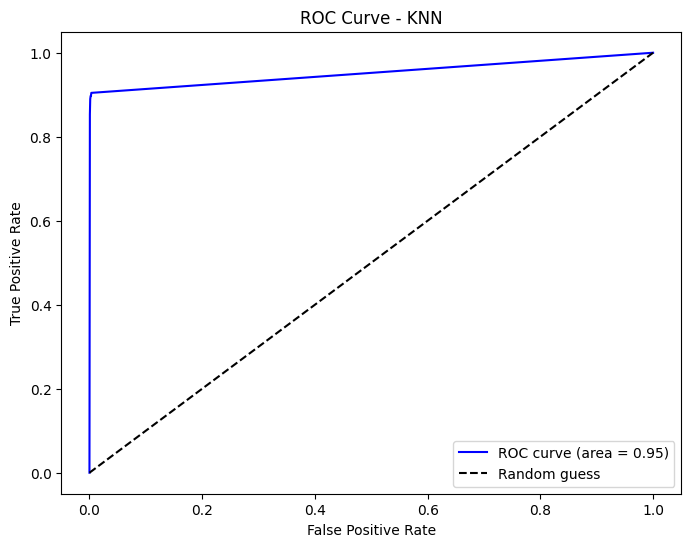

In [38]:
# KNN Modeli
knn = KNeighborsClassifier(n_neighbors=5, algorithm='auto')  # 'auto', 'ball_tree', 'kd_tree', 'brute' seçenekleri
knn.fit(X_train_smote, y_train_smote)

# Test verisiyle tahmin
y_pred_knn = knn.predict(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)[:, 1]  # Sınıf 1'in olasılıklarını al

# Model değerlendirme
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba_knn)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
auc_knn = auc(fpr_knn, tpr_knn)

# ROC Eğrisi çizimi
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label="ROC curve (area = %0.2f)" % auc_knn, color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN")
plt.legend(loc="lower right")
plt.show()


KNN (K-Nearest Neighbors) modeliyle elde edilen sonuçlar, dolandırıcılık tespitinde yüksek bir doğruluk sağlasa da, sınıflar arasında önemli farklar gösteriyor. Ancak, detaylara indiğimizde bazı noktaların dikkat çekici olduğunu görüyoruz.

Confusion Matrix'e bakıldığında, modelin normal işlemleri (Class 0) doğru şekilde ayırt etmekte son derece başarılı olduğunu, sadece 177 yanlış pozitif tahmin yaptığını görebiliyoruz.Ancak dolandırıcılık işlemlerini (Class 1) tespit etme konusunda sadece 122 doğru tespit yapılmış ve 14 vakada yanlış negatif sonuç verilmiş. Bu, modelin recall’unun yüksek (0.90) olduğunu, ancak fazla yanlış pozitif ürettiğini gösteriyor.

Precision değeri ise 0.41'e düşmüş, yani dolandırıcılık olarak sınıflandırılan işlemlerin %41'i doğru. Bu, modelin yanlış pozitiflere oldukça yatkın olduğunu ve dolandırıcılık olarak etiketlenen işlemlerin çoğunun gerçek dolandırıcılık olmayabileceğini işaret ediyor. Bu, dolandırıcılık tespitinde modelin doğruluğunun düşük olduğunu gösteriyor. Ayrıca F1-Score'un 0.56 olduğu görülüyor ki, bu da modelin dolandırıcılık tespitindeki genel performansının, özellikle yanlış pozitiflerin fazla olduğu dikkate alındığında, tatmin edici olmadığını belirtiyor.

ROC-AUC Skoru ise 0.95 ile modelin sınıflar arasındaki ayrımı yapma kapasitesinin oldukça iyi olduğunu gösteriyor, ancak yine de Random Forest (0.98) ve SVM (0.96) modellerinin gerisinde kalıyor.

*Sonuç olarak, KNN modeli genel doğruluk açısından oldukça iyi performans gösterse de, precision ve F1-score'da zayıf kalıyor. Modelin, dolandırıcılık işlemlerini tespit etme oranı yüksek olsa da, yanlış pozitiflerin oranı oldukça yüksek ve bu da modelin güvenilirliğini düşürüyor.*

# 6. Sonuç

*Yaptığımız analizler sonucunda, en uygun modelin Random Forest olduğunu belirledik. Ancak yine de dolandırıcılıkları tahmin etmede yeteri kadar iyi olmadığını söyleyebilriz.*

*Bu durumu değerlendirirken, veri setindeki ciddi sınıf dengesizliğine dikkat çekmek önemlidir. Normal işlemlerin sayısı, dolandırıcılık içeren işlemlere kıyasla oldukça fazladır. Bu dengesizlik, modelin dolandırıcılıkları ayırt etme performansını olumsuz yönde etkiliyor olabilir. Genel olarak modelimiz iyi bir performans sergilese de, dolandırıcılık işlemlerini tespit etme konusunda zorlandığı görülmektedir.*